In [135]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, roc_curve, precision_score
from sklearn.preprocessing import MinMaxScaler

In [136]:
start_date = '2021-01-01'
end_date = '2022-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df = pd.DataFrame({'ds': date_range, 'y': 0})

# Create a column for the month and day
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day

for i, row in df.iterrows():
    if row['day'] == 1:
        iday = 23 + np.random.binomial(4, 0.5)
    
    if row['day'] == iday:
        df.loc[i, 'y'] = 1

df = df.drop(['year','month', 'day'], axis=1)

# Format the ds column as yyyy-mm-dd
df['ds'] = df['ds'].dt.strftime('%Y-%m-%d')



In [137]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=10)
m.fit(df)

09:09:56 - cmdstanpy - INFO - Chain [1] start processing
09:09:56 - cmdstanpy - INFO - Chain [1] done processing


In [138]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1090,2023-12-27
1091,2023-12-28
1092,2023-12-29
1093,2023-12-30
1094,2023-12-31


In [139]:
forecast = m.predict(future)

Text(0.5, 1.0, 'Monthly Investments Forecast Plot')

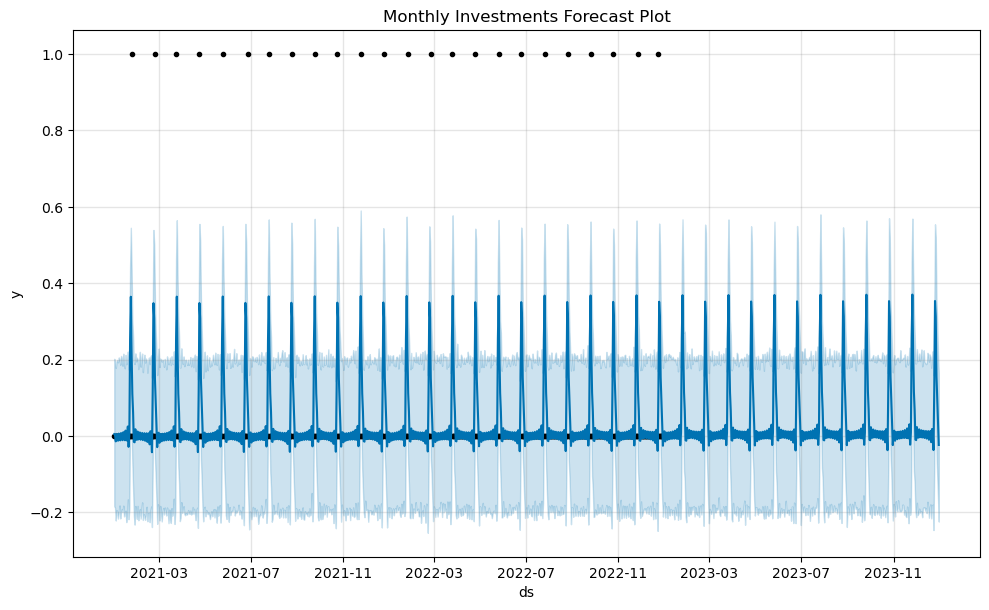

In [140]:
fig1 = m.plot(forecast)
plt.title("Monthly Investments Forecast Plot")

Text(0.5, 1.0, 'Monthly Seasonality')

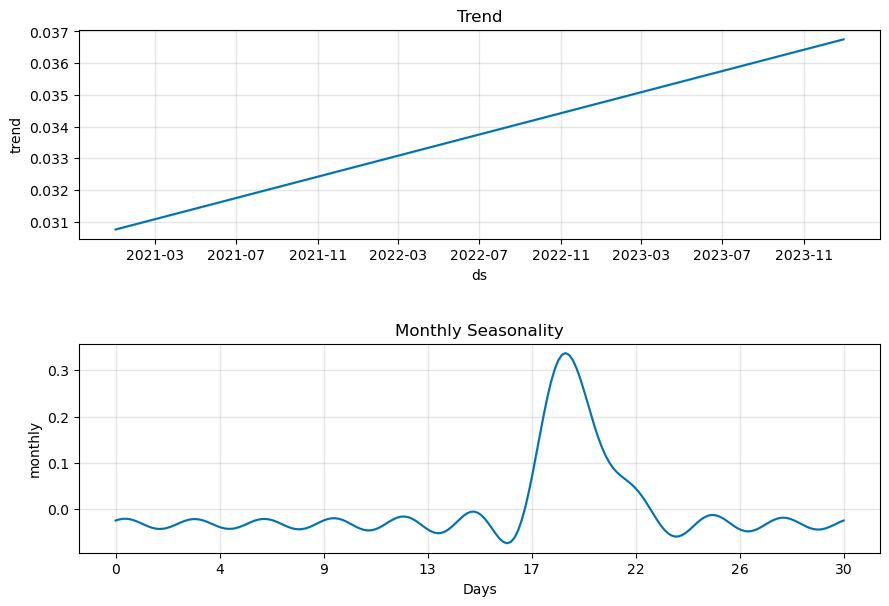

In [141]:
fig2 = m.plot_components(forecast)
plt.subplots_adjust(hspace=0.5)
ax1, ax2 = fig2.get_axes()
ax1.set_title("Trend")
ax2.set_title("Monthly Seasonality")

Make Test Data and Comparision Dataframe

In [145]:
test_start_date = '2023-01-01'
test_end_date = '2023-12-31'

date_range = pd.date_range(start=test_start_date, end=test_end_date, freq='D')
test_df = pd.DataFrame({'ds': date_range, 'y': 0})

# Create a column for the month and day
test_df['year'] = test_df['ds'].dt.year
test_df['month'] = test_df['ds'].dt.month
test_df['day'] = test_df['ds'].dt.day

for i, row in test_df.iterrows():
    if row['day'] == 1:
        iday = 23 + np.random.binomial(4, 0.5)
    
    if row['day'] == iday:
        test_df.loc[i, 'y'] = 1

test_df = test_df.drop(['year','month', 'day'], axis=1)

# Format the ds column as yyyy-mm-dd
test_df['ds'] = test_df['ds'].dt.strftime('%Y-%m-%d')

In [146]:
#Retrieve Forecasted Values
mask = forecast['ds']>= test_start_date
forecast_df = forecast.loc[mask]
forecast_df['ds'] = forecast_df['ds'].dt.strftime('%Y-%m-%d')
forecast_df.head()

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/2329839235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df['ds'] = forecast_df['ds'].dt.strftime('%Y-%m-%d')


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
730,2023-01-01,0.034757,-0.173120,0.210985,0.034757,0.034757,-0.022333,-0.022333,-0.022333,-0.022333,-0.022333,-0.022333,0.0,0.0,0.0,0.012424
731,2023-01-02,0.034763,-0.213260,0.193674,0.034763,0.034763,-0.048765,-0.048765,-0.048765,-0.048765,-0.048765,-0.048765,0.0,0.0,0.0,-0.014002
732,2023-01-03,0.034768,-0.183575,0.214026,0.034768,0.034768,-0.025691,-0.025691,-0.025691,-0.025691,-0.025691,-0.025691,0.0,0.0,0.0,0.009077
733,2023-01-04,0.034773,-0.193704,0.198517,0.034773,0.034773,-0.026749,-0.026749,-0.026749,-0.026749,-0.026749,-0.026749,0.0,0.0,0.0,0.008025
734,2023-01-05,0.034779,-0.214906,0.198993,0.034779,0.034779,-0.044707,-0.044707,-0.044707,-0.044707,-0.044707,-0.044707,0.0,0.0,0.0,-0.009928


In [147]:
#Comparison Dataframe
comp_df=pd.merge(test_df[['ds','y']], forecast_df[['ds','yhat']], how= 'left', on = 'ds')
comp_df.head()

,ds,y,yhat
0,2023-01-01,0,0.012424
1,2023-01-02,0,-0.014002
2,2023-01-03,0,0.009077
3,2023-01-04,0,0.008025
4,2023-01-05,0,-0.009928


Calculate MAE, RMSE, and R-Squared

In [148]:
#Make a dataframe for scoring results for each case
error_df = pd.DataFrame(columns=['case', 'MAE', 'RMSE', 'R-Squared', 'AUC', 'Precision'])
error_df['case'] = [1,2,3,4]
print(error_df)


   case  MAE RMSE R-Squared  AUC Precision
0     1  NaN  NaN       NaN  NaN       NaN
1     2  NaN  NaN       NaN  NaN       NaN
2     3  NaN  NaN       NaN  NaN       NaN
3     4  NaN  NaN       NaN  NaN       NaN


In [149]:
mae = mean_absolute_error(comp_df['y'],comp_df['yhat'])
error_df['MAE'][0]=mae

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/109070131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['MAE'][0]=mae


In [150]:
#Calculate RMSE

rsme = mean_squared_error(comp_df['y'],comp_df['yhat'])
rsme = rsme ** 0.5
error_df['RMSE'][0]=rsme

#Calculate R-Squared

r2 = r2_score(comp_df['y'],comp_df['yhat'])
error_df['R-Squared'][0] = r2

error_df

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/2416496916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['RMSE'][0]=rsme
/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/2416496916.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['R-Squared'][0] = r2


,case,MAE,RMSE,R-Squared,AUC,Precision
0,1,0.06702,0.182119,-0.043133,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN


Calculate AUC and Precision

AUC: 0.6513220018885741
0.0934051078610818


/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/3752193353.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['AUC'][0] = auc


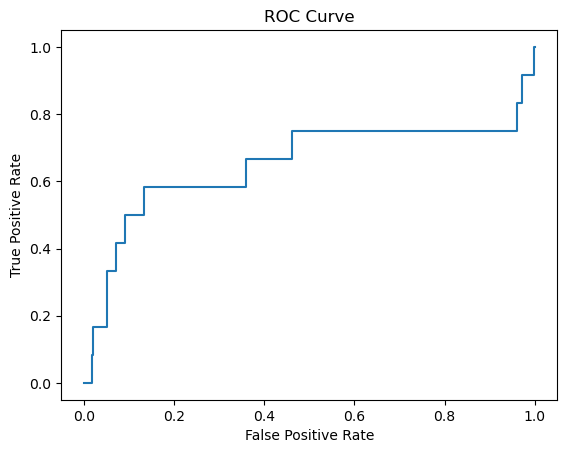

In [151]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(comp_df['y'], comp_df['yhat'])

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Calculate the AUC
auc = roc_auc_score(comp_df['y'], comp_df['yhat'])
error_df['AUC'][0] = auc
print(f'AUC: {auc}')

# Calculate the Youden's J statistic for each threshold value
j_stat = tpr + (1 - fpr) - 1

# Find the optimal threshold value that maximizes the Youden's J statistic
optimal_idx = np.argmax(j_stat)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)



In [152]:
# Change yhat into binary
comp_df['yhat_binary'] = comp_df['yhat'].apply(lambda x: 1 if x > optimal_threshold else 0)

# Calculate Precision
error_df['Precision'][0] = precision_score(comp_df['y'], comp_df['yhat_binary'])

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/529402763.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['Precision'][0] = precision_score(comp_df['y'], comp_df['yhat_binary'])


# 10K AED every 3-5 months

Create dummy data.

In [153]:
start_date = '2021-01-01'
end_date = '2023-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df = pd.DataFrame({'ds': date_range, 'y': 0})

# Create a column for the month and day
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day

#set a top limit for while loop
top = len(df)
#set while loop condition
con = 0
#set day of event at 0
d = 0
while con == 0:
    #we randomly choose one day between 62 and 153 using normal distribution
    rd = np.random.normal(loc=107, scale=16, size=1)[0]
    rd = np.round(rd)
    rd = np.clip(rd, 62, 153)

    #add random days to last day of event
    d = d + rd
    #if new day is within range, set y of said day to 10000; otherwise, end loop
    if d < top:
        df['y'][d]=10000
    else:
        con = 1

df = df.drop(['year','month', 'day'], axis=1)

# Format the ds column as yyyy-mm-dd
df['ds'] = df['ds'].dt.strftime('%Y-%m-%d')

df[df['y']>0]

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/1784195121.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'][d]=10000


,ds,y
114,2021-04-25,10000
230,2021-08-19,10000
348,2021-12-15,10000
451,2022-03-28,10000
542,2022-06-27,10000
657,2022-10-20,10000
747,2023-01-18,10000
846,2023-04-27,10000
960,2023-08-19,10000
1066,2023-12-03,10000


09:12:24 - cmdstanpy - INFO - Chain [1] start processing
09:12:24 - cmdstanpy - INFO - Chain [1] done processing


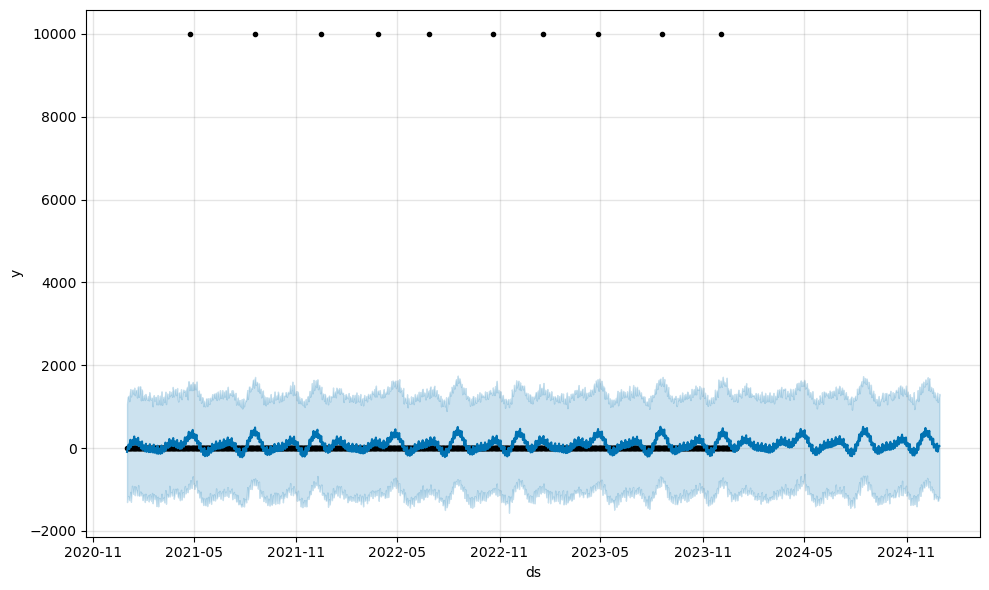

In [154]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)

Normal model is not doing so well. We will try to remove all 0 values

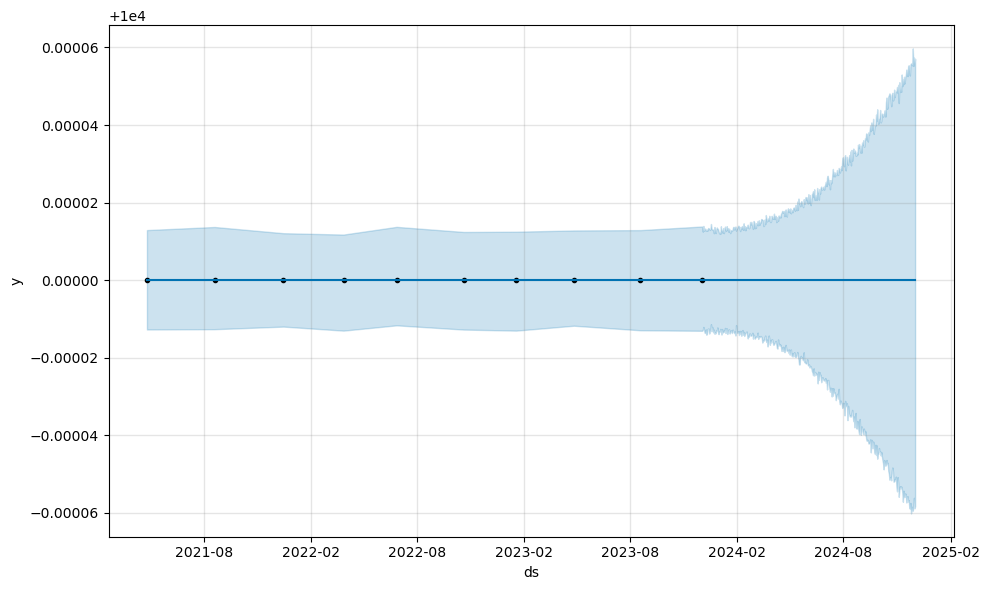

In [155]:
df = df[df['y'] != 0]
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)

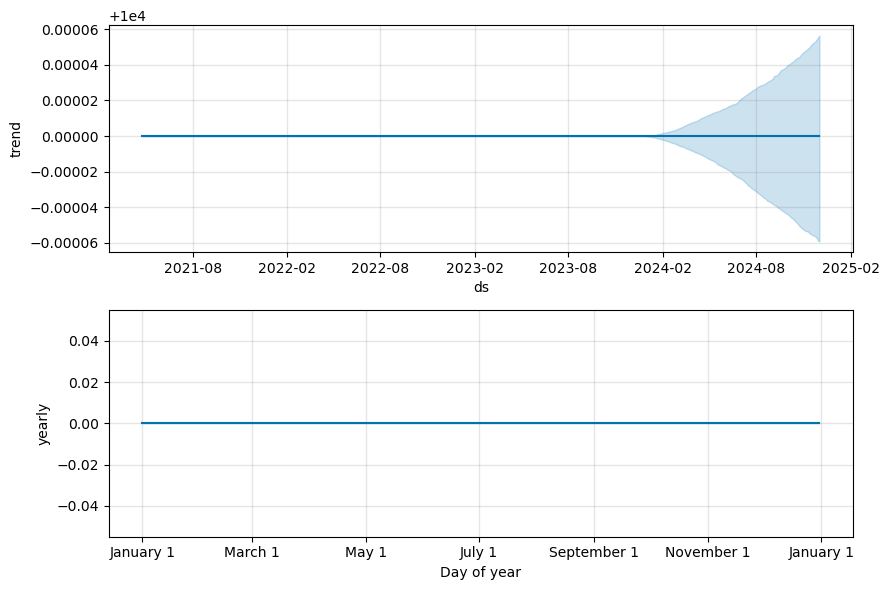

In [156]:
fig2 = m.plot_components(forecast)

Results are abysmal. We will try now changing df into 01-mm-yyyy

In [157]:
start_date = '2020-01-01'
end_date = '2023-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df = pd.DataFrame({'ds': date_range, 'y': 0})

# Create a column for the month and day
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day

#set a top limit for while loop
top = len(df)
#set while loop condition
con = 0
#set day of event at 0
d = 0
while con == 0:
    #we randomly choose one day between 62 and 153 using normal distribution
    rd = np.random.normal(loc=107, scale=16, size=1)[0]
    rd = np.round(rd)
    rd = np.clip(rd, 62, 153)

    #add random days to last day of event
    d = d + rd
    #if new day is within range, set y of said day to 10000; otherwise, end loop
    if d < top:
        df['y'][d]=10000
    else:
        con = 1

df = df.drop(['day'], axis=1)

monthly_sum = df.groupby(['year', 'month'])['y'].sum()

# Reset the index and create a new ds column
monthly_sum = monthly_sum.reset_index()
monthly_sum['ds'] = monthly_sum.apply(lambda x: pd.to_datetime(f"{x['year']}-{x['month']}-01"), axis=1)

# Select only the ds and y columns
df = monthly_sum[['ds', 'y']]


/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/849156011.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'][d]=10000


Split data into training and test dataframes.

In [158]:
# Set the start and end dates for the training and testing sets

train_end = '2022-12-31'
test_start = '2023-01-01'

# Convert the date columns to datetime format
df['ds'] = pd.to_datetime(df['ds'])

# Split the dataframe into train and test sets
train_df = df.loc[(df['ds'] <= train_end)]
test_df = df.loc[df['ds'] >= test_start]

# Reset the indices of the new dataframes
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df.head()

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/3970340215.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = pd.to_datetime(df['ds'])


,ds,y
0,2023-01-01,0
1,2023-02-01,0
2,2023-03-01,0
3,2023-04-01,10000
4,2023-05-01,0


09:12:48 - cmdstanpy - INFO - Chain [1] start processing
09:12:48 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Customer Invests 10K AED Every 3-5 months Forecast Plot')

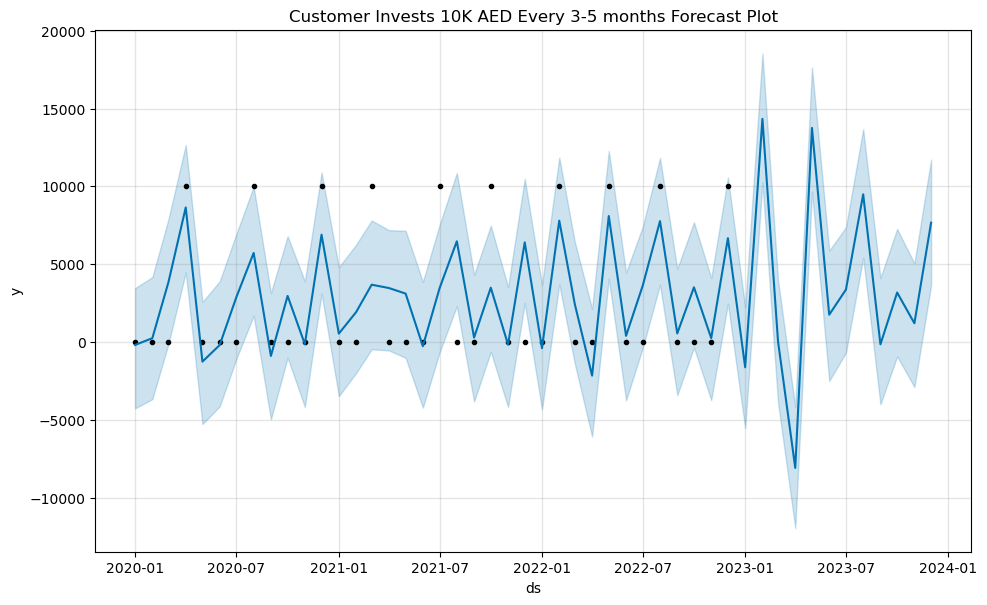

In [159]:
m = Prophet()
m.add_seasonality(name='semi_annually', period=30.5*6, fourier_order=5)
m.fit(train_df)
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title("Customer Invests 10K AED Every 3-5 months Forecast Plot")

Text(0.5, 1.0, 'Semi-Annual Seasonality')

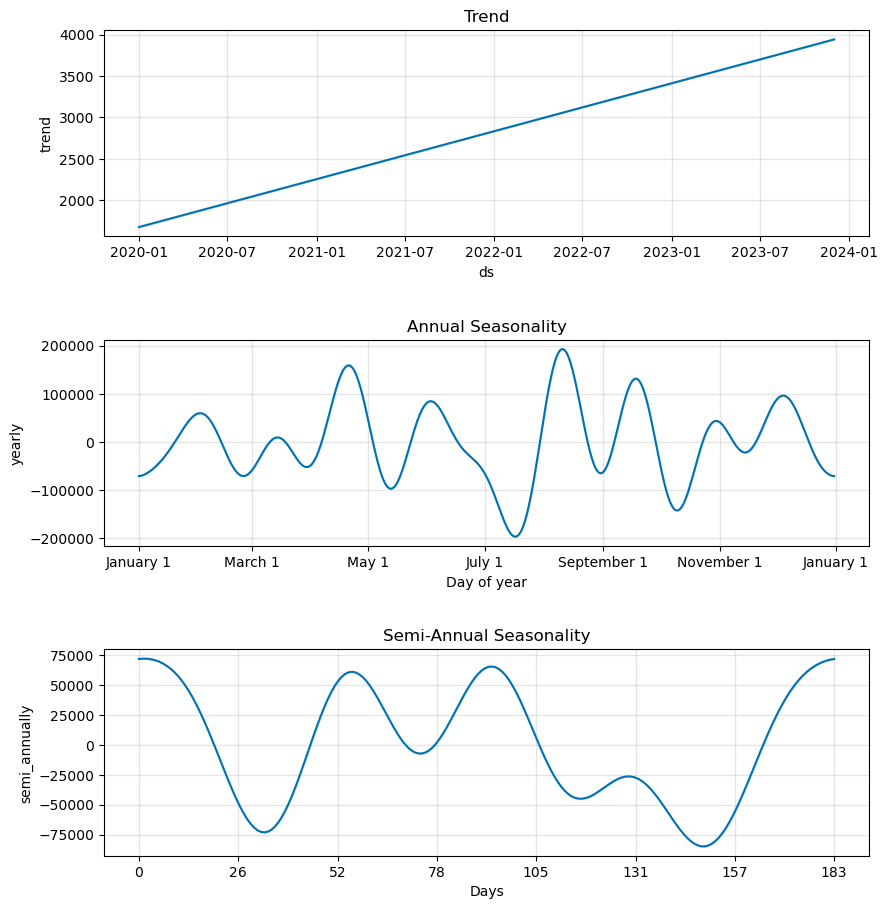

In [160]:
fig2 = m.plot_components(forecast)
plt.subplots_adjust(hspace=0.5)
ax1, ax2, ax3 = fig2.get_axes()
ax1.set_title("Trend")
ax2.set_title("Annual Seasonality")
ax3.set_title("Semi-Annual Seasonality")

Periods are random; causing chaos.

Create Comparision Dataframe

In [161]:
#Retrieve Forecasted Values
mask = forecast['ds']>= test_start_date
forecast_df = forecast.loc[mask]
forecast_df['ds'] = forecast_df['ds'].dt.strftime('%Y-%m-%d')
forecast_df.head()

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/2329839235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df['ds'] = forecast_df['ds'].dt.strftime('%Y-%m-%d')


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,semi_annually,semi_annually_lower,semi_annually_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
36,2023-01-01,3412.473527,-5510.250639,2267.607925,3412.473526,3412.473529,-5012.848501,-5012.848501,-5012.848501,65952.016947,65952.016947,65952.016947,-70964.865447,-70964.865447,-70964.865447,0.0,0.0,0.0,-1600.374974
37,2023-02-01,3461.567048,10256.666791,18527.603000,3461.567043,3461.567054,10876.315298,10876.315298,10876.315298,-47649.441143,-47649.441143,-47649.441143,58525.756441,58525.756441,58525.756441,0.0,0.0,0.0,14337.882346
38,2023-03-01,3505.909584,-3864.994895,4009.195987,3505.909573,3505.909595,-3435.607632,-3435.607632,-3435.607632,58473.449665,58473.449665,58473.449665,-61909.057297,-61909.057297,-61909.057297,0.0,0.0,0.0,70.301951
39,2023-04-01,3555.003105,-11914.054519,-4166.845927,3555.003088,3555.003122,-11615.022500,-11615.022500,-11615.022500,38219.546308,38219.546308,38219.546308,-49834.568808,-49834.568808,-49834.568808,0.0,0.0,0.0,-8060.019395
40,2023-05-01,3602.512964,9660.761903,17634.205512,3602.512941,3602.512989,10154.453180,10154.453180,10154.453180,-44516.156081,-44516.156081,-44516.156081,54670.609261,54670.609261,54670.609261,0.0,0.0,0.0,13756.966145


In [162]:
#Comparison Dataframe
test_df['ds'] = test_df['ds'].dt.strftime('%Y-%m-%d')
comp_df=pd.merge(test_df[['ds','y']], forecast_df[['ds','yhat']], how= 'left', on = 'ds')
comp_df.head()

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/2836421951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ds'] = test_df['ds'].dt.strftime('%Y-%m-%d')


,ds,y,yhat
0,2023-01-01,0,-1600.374974
1,2023-02-01,0,14337.882346
2,2023-03-01,0,70.301951
3,2023-04-01,10000,-8060.019395
4,2023-05-01,0,13756.966145


Calculate MAE, RMSE, and R-Squared

In [163]:
#Calculate Mean Absolute Error
mae = mean_absolute_error(comp_df['y'],comp_df['yhat'])
error_df['MAE'][1] = mae

#Calculate RMSE

rsme = mean_squared_error(comp_df['y'],comp_df['yhat'])
rsme = rsme ** 0.5
error_df['RMSE'][1]=rsme

#Calculate R-Squared

r2 = r2_score(comp_df['y'],comp_df['yhat'])
error_df['R-Squared'][1] = r2

error_df

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/3581418868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['MAE'][1] = mae
/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/3581418868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['RMSE'][1]=rsme
/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/3581418868.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  erro

,case,MAE,RMSE,R-Squared,AUC,Precision
0,1,0.06702,0.182119,-0.043133,0.651322,0.113208
1,2,6104.867075,8585.568021,-2.931306,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN


Change variables from continous to categorical

In [164]:
# Change y to 0 and 1
comp_df['y_binary'] = comp_df['y'].apply(lambda x: 1 if x > 0 else 0)

# Scale yhat between 0 and 1
scaler = MinMaxScaler()
comp_df['yhat_scaled'] = scaler.fit_transform(comp_df[['yhat']])

Calculate AUC and Precision

AUC: 0.37037037037037035
0.7837659332187755


/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/1650741663.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['AUC'][1] = auc


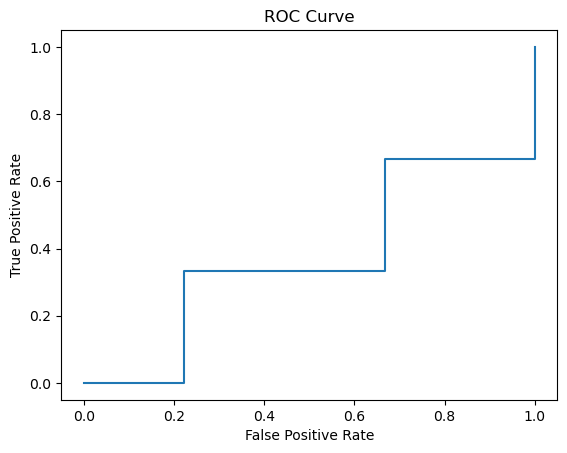

In [165]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(comp_df['y_binary'], comp_df['yhat_scaled'])

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Calculate the AUC
auc = roc_auc_score(comp_df['y_binary'], comp_df['yhat_scaled'])
error_df['AUC'][1] = auc
print(f'AUC: {auc}')

# Calculate the Youden's J statistic for each threshold value
j_stat = tpr + (1 - fpr) - 1

# Find the optimal threshold value that maximizes the Youden's J statistic
optimal_idx = np.argmax(j_stat)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

In [166]:
# Change yhat into binary
comp_df['yhat_binary'] = comp_df['yhat_scaled'].apply(lambda x: 1 if x > optimal_threshold else 0)

# Calculate Precision
precision = precision_score(comp_df['y_binary'], comp_df['yhat_binary'])
error_df['Precision'][1] = precision

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/2241370174.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['Precision'][1] = precision


# Small amounts every few weeks

In [167]:
start_date = '2021-01-01'
end_date = '2023-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df = pd.DataFrame({'ds': date_range, 'y': 0})

# Create a column for the month and day
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day

#set a top limit for while loop
top = len(df)
#set while loop condition
con = 0
#set day of event at 0
d = 0
while con == 0:
    #we randomly choose one day between 14 and 28 using normal distribution
    rd = np.random.normal(loc=21, scale=4, size=1)[0]
    rd = np.round(rd)
    rd = np.clip(rd, 14, 28)

    #add random days to last day of event
    d = d + rd
    #if new day is within range, set y of said day to around 1000; otherwise, end loop
    if d < top:
        df['y'][d]=1000 + np.random.normal(loc=100, scale=50, size=1)[0]
    else:
        con = 1

df = df.drop(['year','month', 'day'], axis=1)

# Format the ds column as yyyy-mm-dd
df['ds'] = df['ds'].dt.strftime('%Y-%m-%d')

df[df['y']>0]

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/2554936733.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'][d]=1000 + np.random.normal(loc=100, scale=50, size=1)[0]


,ds,y
28,2021-01-29,999.511424
51,2021-02-21,1209.623492
71,2021-03-13,1087.303604
85,2021-03-27,1139.663388
110,2021-04-21,1161.682763
135,2021-05-16,1167.650140
161,2021-06-11,1128.076683
185,2021-07-05,1140.451090
207,2021-07-27,1116.320591
235,2021-08-24,1069.373413


09:13:37 - cmdstanpy - INFO - Chain [1] start processing
09:13:37 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Customer Invests 1k AED Every 3-4 Weeks Forecast Plot')

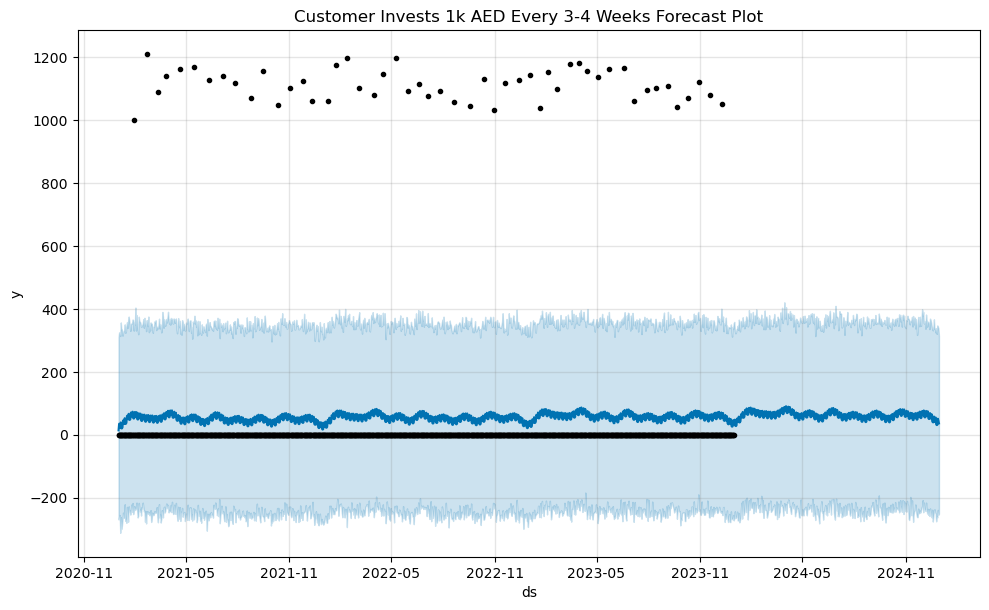

In [168]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title("Customer Invests 1k AED Every 3-4 Weeks Forecast Plot")

ValueError: too many values to unpack (expected 2)

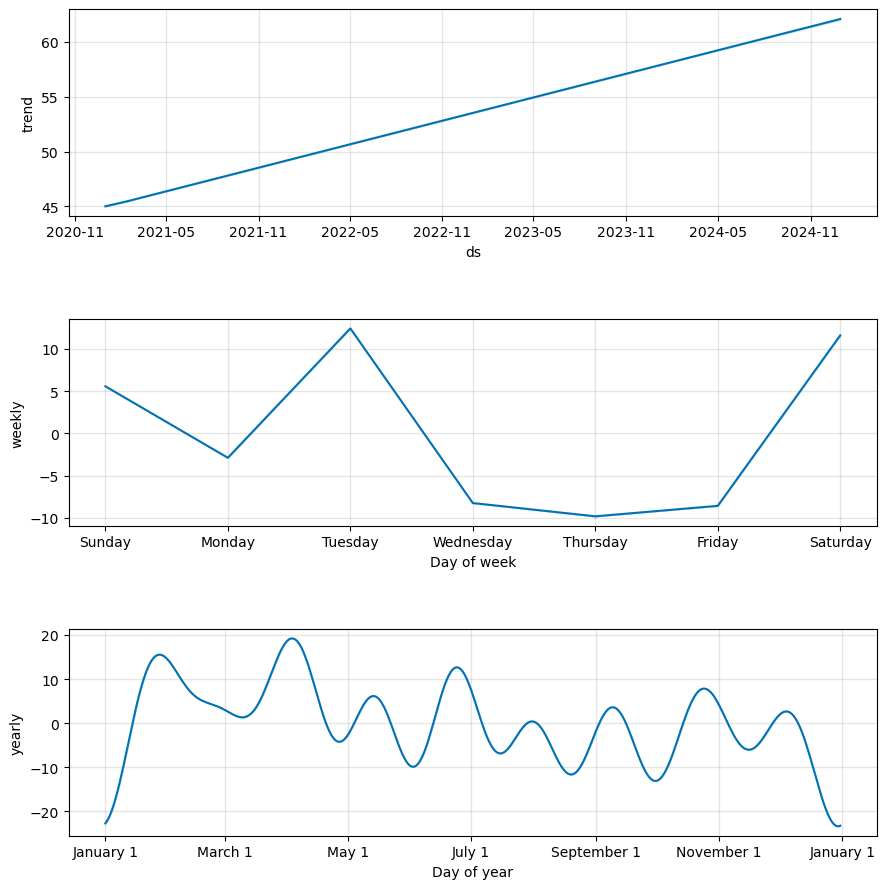

In [169]:
fig2 = m.plot_components(forecast)
plt.subplots_adjust(hspace=0.5)
ax1, ax2 = fig2.get_axes()
ax1.set_title("Trend")
ax2.set_title("Weekly Seasonality")

Weekly seems like a bad idea. I will add a 9 week period instead

09:13:42 - cmdstanpy - INFO - Chain [1] start processing
09:13:42 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Customer Invests 1k AED Every 3-4 Weeks Forecast Plot')

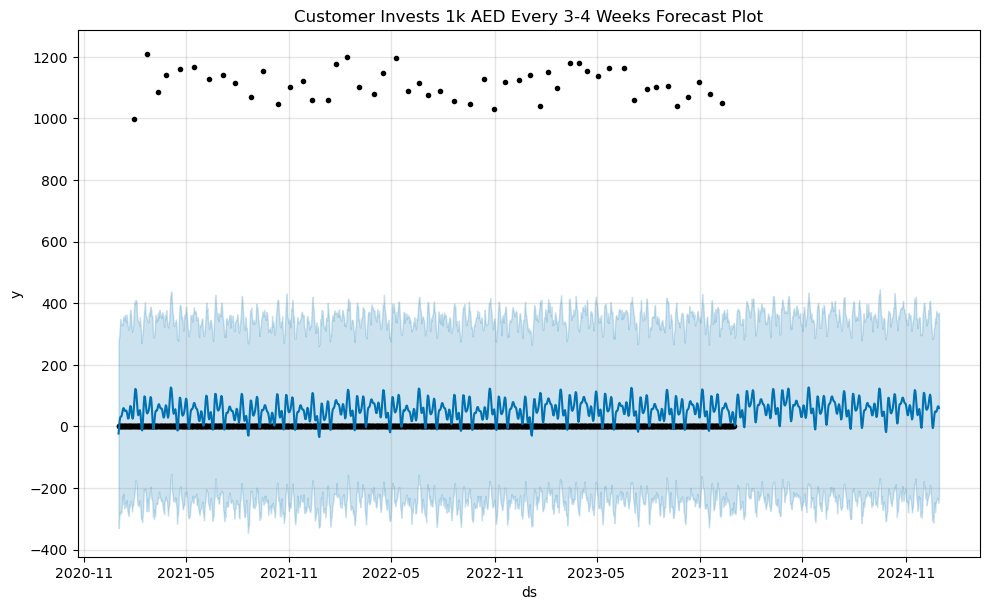

In [170]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='9_weeks', period=7*9, fourier_order=10)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title("Customer Invests 1k AED Every 3-4 Weeks Forecast Plot")

Text(0.5, 1.0, '9-Week Seasonality')

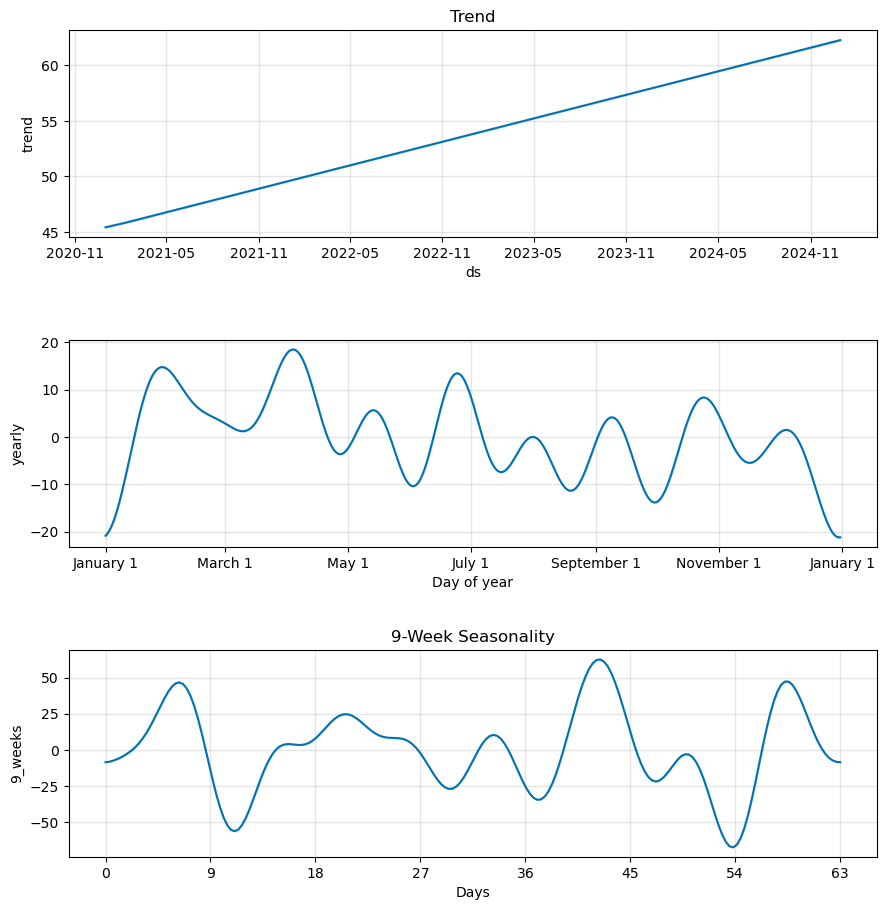

In [171]:
fig2 = m.plot_components(forecast)
plt.subplots_adjust(hspace=0.5)
ax1, ax2, ax3 = fig2.get_axes()
ax1.set_title("Trend")
ax3.set_title("9-Week Seasonality")

Let us try weekly resolution

In [172]:
# Convert the 'ds' column to datetime format
df['ds'] = pd.to_datetime(df['ds'])

# Set the index of the dataframe to the 'ds' column
df = df.set_index('ds')

# Resample the dataframe to weekly frequency and sum the 'y' column
df = df.resample('W')['y'].sum()

# Reset the index of the resulting weekly sum DataFrame
df = df.reset_index()

# Print the resulting weekly sum DataFrame
print(df)

            ds            y
0   2021-01-03     0.000000
1   2021-01-10     0.000000
2   2021-01-17     0.000000
3   2021-01-24     0.000000
4   2021-01-31   999.511424
..         ...          ...
152 2023-12-03     0.000000
153 2023-12-10     0.000000
154 2023-12-17  1050.620128
155 2023-12-24     0.000000
156 2023-12-31     0.000000

[157 rows x 2 columns]


Split data to train and test dataframes

In [173]:
train_end = '2022-12-31'
test_start = '2023-01-01'

# Convert the date columns to datetime format
df['ds'] = pd.to_datetime(df['ds'])

# Split the dataframe into train and test sets
train_df = df.loc[(df['ds'] <= train_end)]
test_df = df.loc[df['ds'] >= test_start]

# Reset the indices of the new dataframes
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df.head()

,ds,y
0,2023-01-01,0.000000
1,2023-01-08,1141.257638
2,2023-01-15,0.000000
3,2023-01-22,1039.415304
4,2023-01-29,0.000000


09:13:56 - cmdstanpy - INFO - Chain [1] start processing
09:13:56 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Customer Invests 1k AED Every 3-4 Weeks Forecast Plot')

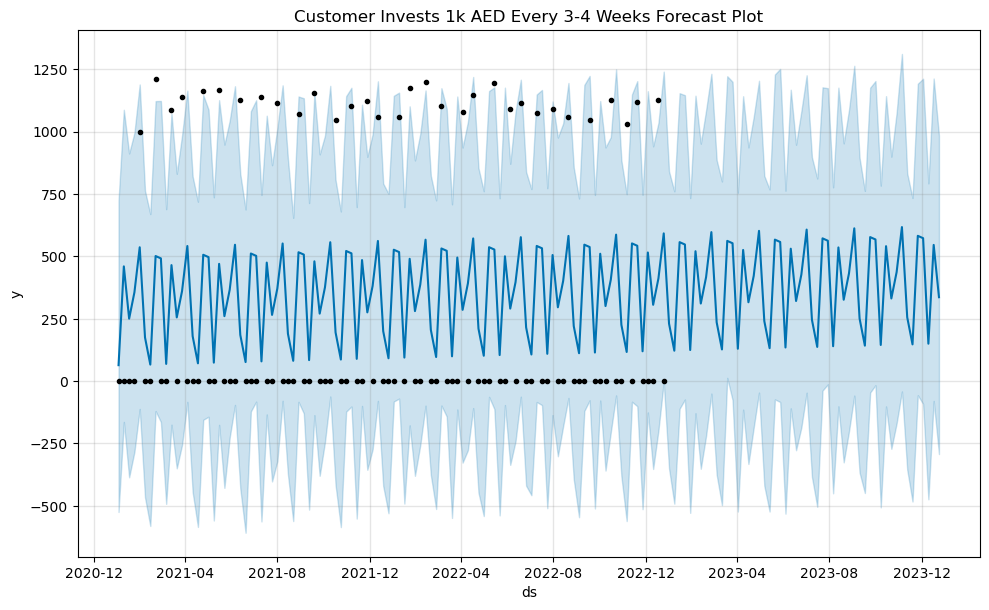

In [174]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='9_weeks', period=7*9, fourier_order=10)
m.fit(train_df)
future = m.make_future_dataframe(periods=52, freq = 'W')
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title("Customer Invests 1k AED Every 3-4 Weeks Forecast Plot")

Text(0.5, 1.0, '9-Week Seasonality')

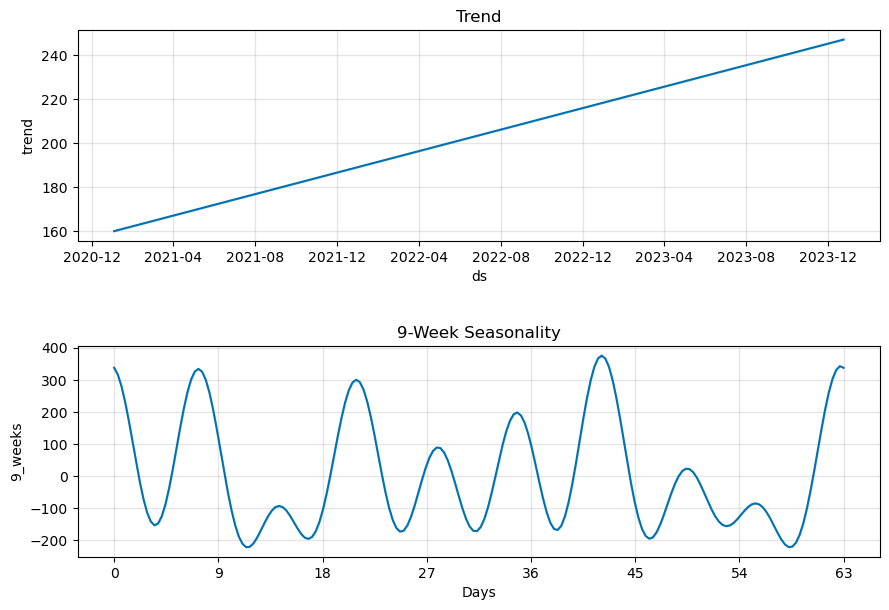

In [175]:
fig2 = m.plot_components(forecast)
plt.subplots_adjust(hspace=0.5)
ax1, ax2 = fig2.get_axes()
ax1.set_title("Trend")
ax2.set_title("9-Week Seasonality")

Well...

Create Comparision Dataframe

In [176]:
#Retrieve Forecasted Values
mask = forecast['ds']>= test_start_date
forecast_df = forecast.loc[mask]
forecast_df['ds'] = forecast_df['ds'].dt.strftime('%Y-%m-%d')
forecast_df.head()

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/2329839235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df['ds'] = forecast_df['ds'].dt.strftime('%Y-%m-%d')


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,9_weeks,9_weeks_lower,9_weeks_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
104,2023-01-01,218.504203,-350.207991,840.909634,218.504203,218.504203,12.026116,12.026116,12.026116,12.026116,12.026116,12.026116,0.0,0.0,0.0,230.530319
105,2023-01-08,219.066598,-491.348473,760.734859,219.066598,219.066599,-97.187237,-97.187237,-97.187237,-97.187237,-97.187237,-97.187237,0.0,0.0,0.0,121.879361
106,2023-01-15,219.628994,-110.631763,1154.115545,219.628994,219.628994,337.345664,337.345664,337.345664,337.345664,337.345664,337.345664,0.0,0.0,0.0,556.974658
107,2023-01-22,220.191390,-73.813851,1146.075048,220.191389,220.191390,327.367111,327.367111,327.367111,327.367111,327.367111,327.367111,0.0,0.0,0.0,547.558500
108,2023-01-29,220.753785,-528.224117,733.726038,220.753784,220.753786,-96.148630,-96.148630,-96.148630,-96.148630,-96.148630,-96.148630,0.0,0.0,0.0,124.605155


In [178]:
#Comparison Dataframe
test_df['ds'] = test_df['ds'].dt.strftime('%Y-%m-%d')
comp_df=pd.merge(test_df[['ds','y']], forecast_df[['ds','yhat']], how= 'left', on = 'ds')

#Last row has NA, so we will drop it like it is hot
comp_df = comp_df.drop(comp_df.index[-1])
comp_df.tail()

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/425006861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ds'] = test_df['ds'].dt.strftime('%Y-%m-%d')


,ds,y,yhat
47,2023-11-26,0.000000,582.282458
48,2023-12-03,0.000000,572.866300
49,2023-12-10,0.000000,149.912955
50,2023-12-17,1050.620128,545.921767
51,2023-12-24,0.000000,336.316992


Calculate MAE, RMSE, and R-Squared

In [179]:
#Calculate Mean Absolute Error
mae = mean_absolute_error(comp_df['y'],comp_df['yhat'])
error_df['MAE'][2] = mae

#Calculate RMSE

rsme = mean_squared_error(comp_df['y'],comp_df['yhat'])
rsme = rsme ** 0.5
error_df['RMSE'][2]=rsme

#Calculate R-Squared

r2 = r2_score(comp_df['y'],comp_df['yhat'])
error_df['R-Squared'][2] = r2

error_df

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/1160291000.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['MAE'][2] = mae
/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/1160291000.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['RMSE'][2]=rsme
/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/1160291000.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  erro

,case,MAE,RMSE,R-Squared,AUC,Precision
0,1,0.06702,0.182119,-0.043133,0.651322,0.113208
1,2,6104.867075,8585.568021,-2.931306,0.37037,0.0
2,3,497.168924,553.378554,-0.065138,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN


Change variables from continous to Boolean

In [180]:
# Change y to 0 and 1
comp_df['y_binary'] = comp_df['y'].apply(lambda x: 1 if x > 0 else 0)

# Scale yhat between 0 and 1
scaler = MinMaxScaler()
comp_df['yhat_scaled'] = scaler.fit_transform(comp_df[['yhat']])

Calculate AUC and Precision

AUC: 0.5390749601275917
0.23967891901008376


/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/4102647680.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['AUC'][2] = auc


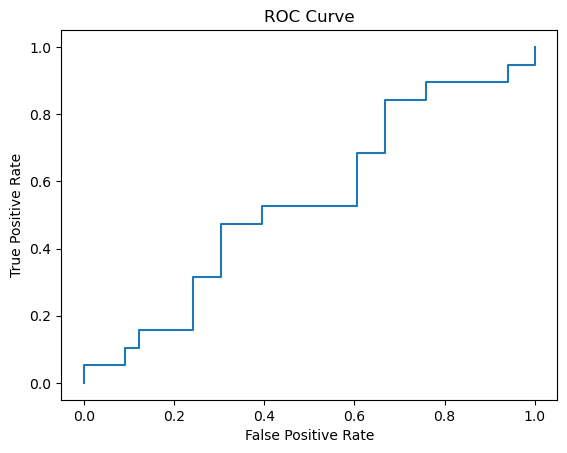

In [181]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(comp_df['y_binary'], comp_df['yhat_scaled'])

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Calculate the AUC
auc = roc_auc_score(comp_df['y_binary'], comp_df['yhat_scaled'])
error_df['AUC'][2] = auc
print(f'AUC: {auc}')

# Calculate the Youden's J statistic for each threshold value
j_stat = tpr + (1 - fpr) - 1

# Find the optimal threshold value that maximizes the Youden's J statistic
optimal_idx = np.argmax(j_stat)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

In [182]:
# Change yhat into binary
comp_df['yhat_binary'] = comp_df['yhat_scaled'].apply(lambda x: 1 if x > optimal_threshold else 0)

# Calculate Precision
precision = precision_score(comp_df['y_binary'], comp_df['yhat_binary'])
error_df['Precision'][2] = precision

error_df

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/1174815554.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['Precision'][2] = precision


,case,MAE,RMSE,R-Squared,AUC,Precision
0,1,0.06702,0.182119,-0.043133,0.651322,0.113208
1,2,6104.867075,8585.568021,-2.931306,0.37037,0.0
2,3,497.168924,553.378554,-0.065138,0.539075,0.405405
3,4,NaN,NaN,NaN,NaN,NaN


# Two large amounts each year for the past 3 years

Assume 6 months interval

In [183]:
start_date = '2019-01-01'
end_date = '2023-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='M')
df = pd.DataFrame({'ds': date_range, 'y': 0})

# Create a column for the month and day
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month

# Set the y value to 1000000 for months 6 and 12
df.loc[(df['month'] == 6) | (df['month'] == 12), 'y'] = np.random.normal(loc=1000000, scale=300000, size=10)

df = df.drop(['year','month'], axis=1)

# Format the ds column as yyyy-mm-dd
df['ds'] = df['ds'].dt.strftime('%Y-%m-%d')

Split data into test and train

In [184]:
train_end = '2022-12-31'
test_start = '2023-01-01'

# Convert the date columns to datetime format
df['ds'] = pd.to_datetime(df['ds'])

# Split the dataframe into train and test sets
train_df = df.loc[(df['ds'] <= train_end)]
test_df = df.loc[df['ds'] >= test_start]

# Reset the indices of the new dataframes
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df.head()

,ds,y
0,2023-01-31,0.0
1,2023-02-28,0.0
2,2023-03-31,0.0
3,2023-04-30,0.0
4,2023-05-31,0.0


09:15:08 - cmdstanpy - INFO - Chain [1] start processing
09:15:08 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Customer Invests 1M AED Semi-Annually Forecast Plot')

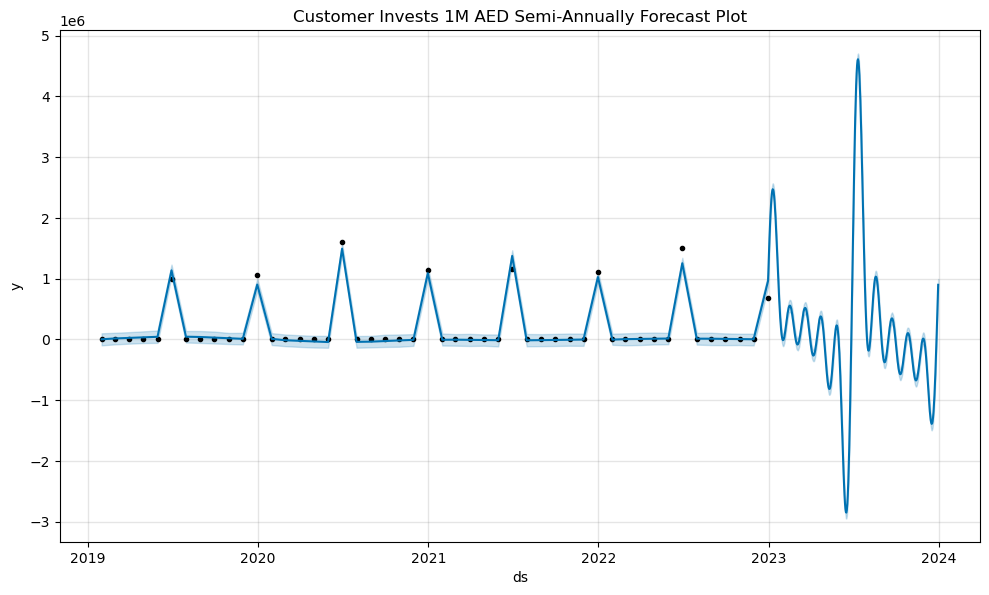

In [185]:
m = Prophet()
m.fit(train_df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title("Customer Invests 1M AED Semi-Annually Forecast Plot")

Text(0.5, 1.0, 'Semi-Annual Seasonality')

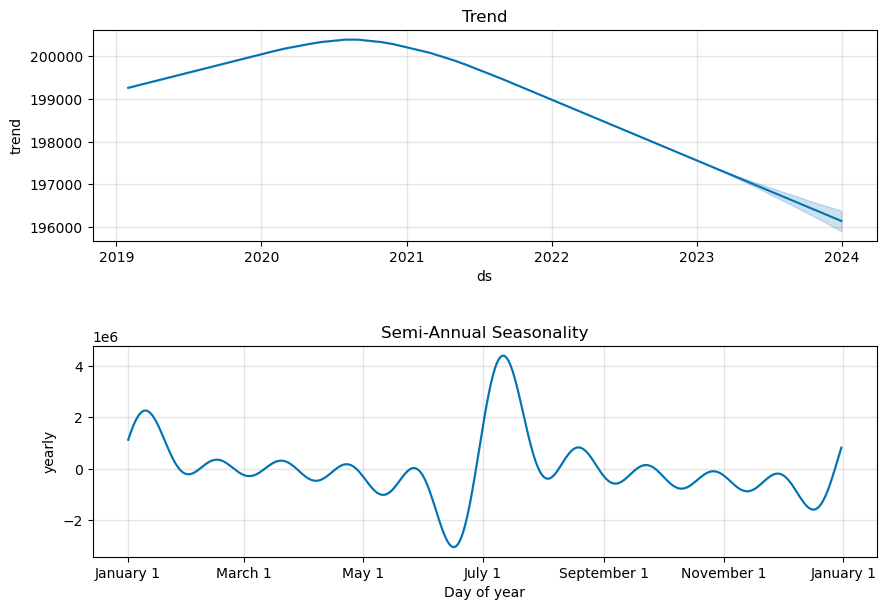

In [186]:
fig2 = m.plot_components(forecast)
plt.subplots_adjust(hspace=0.5)
ax1, ax2 = fig2.get_axes()
ax1.set_title("Trend")
ax2.set_title("Semi-Annual Seasonality")

Seems like cutoff makes a problem, and fourier needs more. We will try to do biannual period and more fourier.

09:15:15 - cmdstanpy - INFO - Chain [1] start processing
09:15:15 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Customer Invests 1M AED Semi-Annually Forecast Plot')

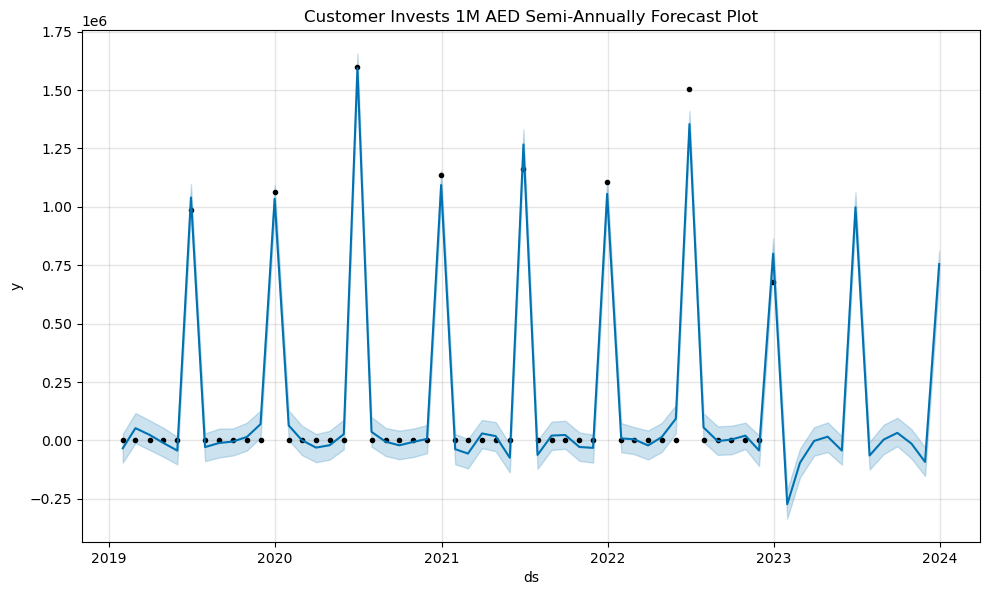

In [187]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='biannual', period=365*2, fourier_order=5)
m.fit(train_df)
future = m.make_future_dataframe(periods=12, freq = 'M')
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title("Customer Invests 1M AED Semi-Annually Forecast Plot")

Text(0.5, 1.0, 'Bi-Annual Seasonality')

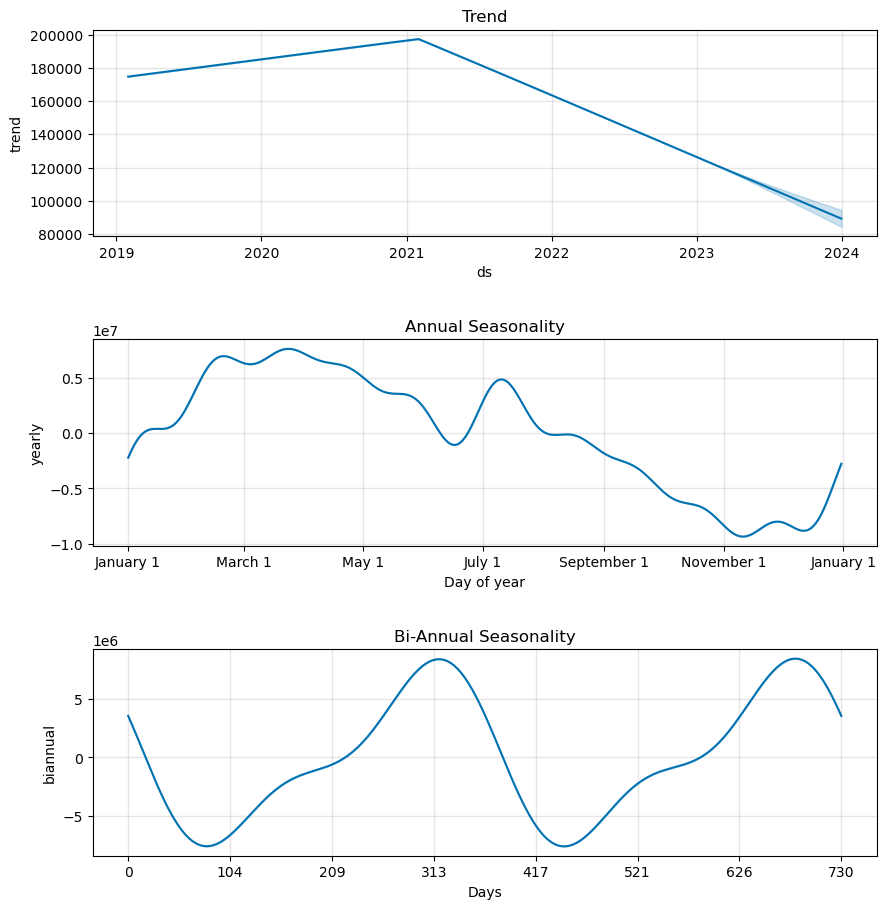

In [188]:
fig2 = m.plot_components(forecast)
plt.subplots_adjust(hspace=0.5)
ax1, ax2, ax3 = fig2.get_axes()
ax1.set_title("Trend")
ax2.set_title("Annual Seasonality")
ax3.set_title("Bi-Annual Seasonality")

Create Comparision Dataframe

In [189]:
#Retrieve Forecasted Values
mask = forecast['ds']>= test_start_date
forecast_df = forecast.loc[mask]
forecast_df['ds'] = forecast_df['ds'].dt.strftime('%Y-%m-%d')
forecast_df.head()

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/2329839235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df['ds'] = forecast_df['ds'].dt.strftime('%Y-%m-%d')


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,biannual,biannual_lower,biannual_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
48,2023-01-31,123319.749649,-334490.051917,-211797.042087,123234.602521,123401.937842,-396838.868404,-396838.868404,-396838.868404,-2.620397e+06,-2.620397e+06,-2.620397e+06,2.223558e+06,2.223558e+06,2.223558e+06,0.0,0.0,0.0,-273519.118755
49,2023-02-28,120468.772555,-159072.531288,-34987.194550,120188.295585,120756.537648,-216352.696645,-216352.696645,-216352.696645,-6.651280e+06,-6.651280e+06,-6.651280e+06,6.434928e+06,6.434928e+06,6.434928e+06,0.0,0.0,0.0,-95883.924089
50,2023-03-31,117312.333630,-65665.447518,56164.143807,116748.434710,117890.387483,-119858.542630,-119858.542630,-119858.542630,-7.436386e+06,-7.436386e+06,-7.436386e+06,7.316527e+06,7.316527e+06,7.316527e+06,0.0,0.0,0.0,-2546.209001
51,2023-04-30,114257.715315,-50065.731345,76539.372843,113398.623759,115213.606266,-98599.405234,-98599.405234,-98599.405234,-5.348394e+06,-5.348394e+06,-5.348394e+06,5.249794e+06,5.249794e+06,5.249794e+06,0.0,0.0,0.0,15658.310080
52,2023-05-31,111101.276389,-104247.050447,17719.304380,109818.653143,112446.231528,-154860.982974,-154860.982974,-154860.982974,-2.772537e+06,-2.772537e+06,-2.772537e+06,2.617676e+06,2.617676e+06,2.617676e+06,0.0,0.0,0.0,-43759.706585


In [190]:
#Comparison Dataframe
test_df['ds'] = test_df['ds'].dt.strftime('%Y-%m-%d')
comp_df=pd.merge(test_df[['ds','y']], forecast_df[['ds','yhat']], how= 'left', on = 'ds')


/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/2414119943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ds'] = test_df['ds'].dt.strftime('%Y-%m-%d')


Calculate MAE, RSME, and R-Squared

In [191]:
#Calculate Mean Absolute Error
mae = mean_absolute_error(comp_df['y'],comp_df['yhat'])
error_df['MAE'][3] = mae

#Calculate RMSE

rsme = mean_squared_error(comp_df['y'],comp_df['yhat'])
rsme = rsme ** 0.5
error_df['RMSE'][3]=rsme

#Calculate R-Squared

r2 = r2_score(comp_df['y'],comp_df['yhat'])
error_df['R-Squared'][3] = r2

error_df

/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/4277419594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['MAE'][3] = mae
/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/4277419594.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['RMSE'][3]=rsme
/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/4277419594.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  erro

,case,MAE,RMSE,R-Squared,AUC,Precision
0,1,0.06702,0.182119,-0.043133,0.651322,0.113208
1,2,6104.867075,8585.568021,-2.931306,0.37037,0.0
2,3,497.168924,553.378554,-0.065138,0.539075,0.405405
3,4,66037.091512,96686.502239,0.911285,NaN,NaN


Convert continous variables to Boolean

In [192]:
# Change y to 0 and 1
comp_df['y_binary'] = comp_df['y'].apply(lambda x: 1 if x > 0 else 0)

# Scale yhat between 0 and 1
scaler = MinMaxScaler()
comp_df['yhat_scaled'] = scaler.fit_transform(comp_df[['yhat']])

Calcualte AUC and Precision

AUC: 1.0
0.8086699066497327


/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/856292812.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['AUC'][3] = auc
/var/folders/_f/fyj5g6rn3s74bjqhs95txbk40000gn/T/ipykernel_23739/856292812.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['Precision'][3] = precision


,case,MAE,RMSE,R-Squared,AUC,Precision
0,1,0.06702,0.182119,-0.043133,0.651322,0.113208
1,2,6104.867075,8585.568021,-2.931306,0.37037,0.0
2,3,497.168924,553.378554,-0.065138,0.539075,0.405405
3,4,66037.091512,96686.502239,0.911285,1.0,1.0


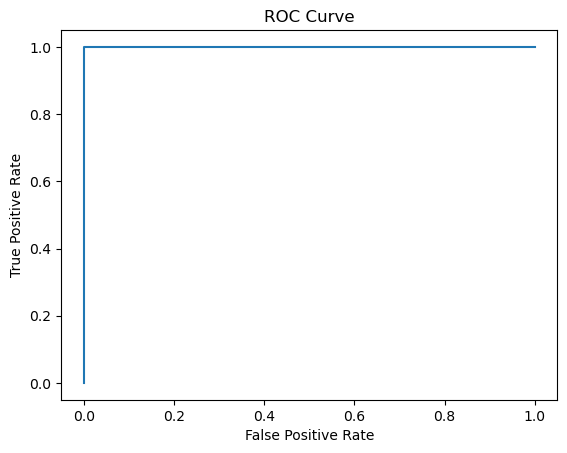

In [193]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(comp_df['y_binary'], comp_df['yhat_scaled'])

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Calculate the AUC
auc = roc_auc_score(comp_df['y_binary'], comp_df['yhat_scaled'])
error_df['AUC'][3] = auc
print(f'AUC: {auc}')

# Calculate the Youden's J statistic for each threshold value
j_stat = tpr + (1 - fpr) - 1

# Find the optimal threshold value that maximizes the Youden's J statistic
optimal_idx = np.argmax(j_stat)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

# Change yhat into binary
comp_df['yhat_binary'] = comp_df['yhat_scaled'].apply(lambda x: 1 if x > optimal_threshold else 0)

# Calculate Precision
precision = precision_score(comp_df['y_binary'], comp_df['yhat_binary'])
error_df['Precision'][3] = precision

error_df